In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
# 한글 폰트 설정 (MacOS 전용)
mpl.rcParams['font.family'] = 'AppleGothic'
# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False
import holidays
from datetime import datetime

Test MSE: 0.1671


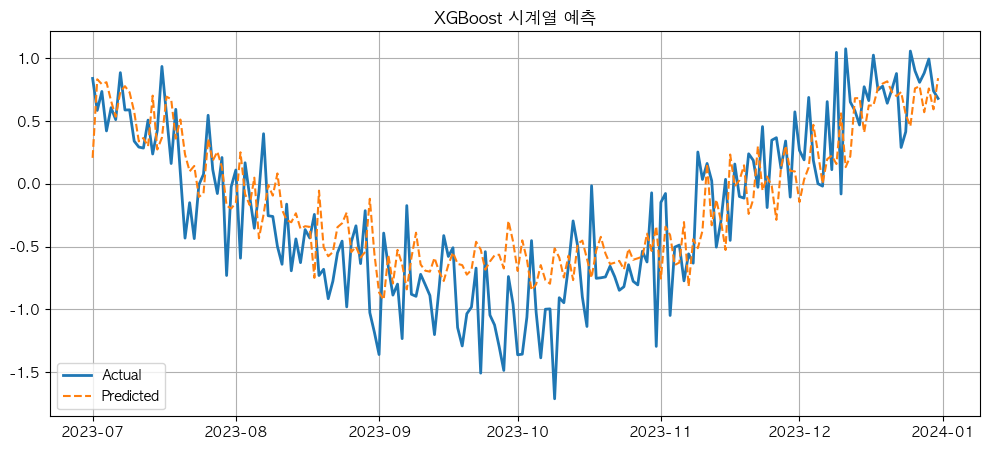

In [15]:
# 🟦 1. 예제 시계열 생성
date_range = pd.date_range(start="2022-01-01", end="2023-12-31")
np.random.seed(42)
data = pd.DataFrame({
    "date": date_range,
    "y": np.sin(np.linspace(0, 20, len(date_range))) + np.random.normal(0, 0.3, len(date_range))
})
data.set_index("date", inplace=True)

# 🟦 2. 시계열 feature 생성 함수
def create_features(df, lags=[1, 2, 7]):
    df_feat = df.copy()
    df_feat["dayofweek"] = df_feat.index.dayofweek
    df_feat["month"] = df_feat.index.month
    df_feat["day"] = df_feat.index.day
    df_feat["is_weekend"] = df_feat["dayofweek"].isin([5,6]).astype(int)
    
    # 공휴일 여부
    kr_holidays = holidays.KR()
    df_feat["is_holiday"] = df_feat.index.to_series().apply(lambda x: int(x in kr_holidays))
    
    for lag in lags:
        df_feat[f"lag_{lag}"] = df_feat["y"].shift(lag)
    
    df_feat.dropna(inplace=True)
    return df_feat

df = create_features(data)

# 🟦 3. Train/Test split
train = df.loc[:"2023-06-30"]
test = df.loc["2023-07-01":]

X_train, y_train = train.drop(columns="y"), train["y"]
X_test, y_test = test.drop(columns="y"), test["y"]

# 🟦 4. XGBoost 모델 학습
model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(X_train, y_train)

# 🟦 5. 예측 및 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

# 🟦 6. 시각화
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred, label="Predicted", linestyle="--")
plt.title("XGBoost 시계열 예측")
plt.legend()
plt.grid()
plt.show()

In [16]:
data

,y
date,
2022-01-01,0.149014
2022-01-02,-0.014048
2022-01-03,0.249149
2022-01-04,0.539121
2022-01-05,0.039273
...,...
2023-12-27,0.807566
2023-12-28,0.881836
2023-12-29,0.993466


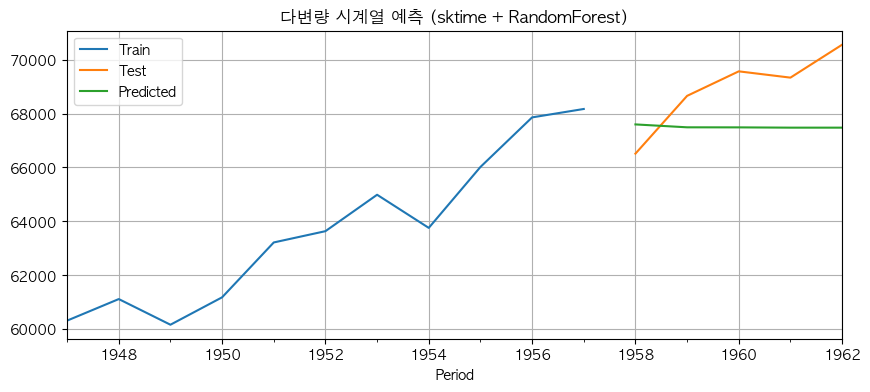

In [17]:
from sktime.datasets import load_longley
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

# 1. 데이터 불러오기
y, X = load_longley()

# 2. 훈련/테스트 분할
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=5)

# 3. 모델 구성 (sktime에서 sklearn 모델로 시계열 예측)
regressor = RandomForestRegressor()
model = make_reduction(regressor, strategy="recursive", window_length=5, scitype="infer")

# 4. 학습 및 예측
model.fit(y_train, X=X_train)
y_pred = model.predict(fh=list(range(1, len(y_test)+1)), X=X_test)

# 5. 시각화
plt.figure(figsize=(10, 4))
y_train.plot(label="Train")
y_test.plot(label="Test")
y_pred.plot(label="Predicted")
plt.legend()
plt.title("다변량 시계열 예측 (sktime + RandomForest)")
plt.grid()
plt.show()

In [21]:
y

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
1952    63639.0
1953    64989.0
1954    63761.0
1955    66019.0
1956    67857.0
1957    68169.0
1958    66513.0
1959    68655.0
1960    69564.0
1961    69331.0
1962    70551.0
Freq: Y-DEC, Name: TOTEMP, dtype: float64